<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Three-ways-to-solve-RL-problems" data-toc-modified-id="Three-ways-to-solve-RL-problems-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Three ways to solve RL problems</a></span></li><li><span><a href="#Dynamic-programming:-Value-and-Policy-Iteration" data-toc-modified-id="Dynamic-programming:-Value-and-Policy-Iteration-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dynamic programming: Value and Policy Iteration</a></span><ul class="toc-item"><li><span><a href="#Imports-&amp;-Settings" data-toc-modified-id="Imports-&amp;-Settings-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Imports &amp; Settings</a></span></li><li><span><a href="#Set-up-Gridworld" data-toc-modified-id="Set-up-Gridworld-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Set up Gridworld</a></span><ul class="toc-item"><li><span><a href="#States,-Actions-and-Rewards" data-toc-modified-id="States,-Actions-and-Rewards-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>States, Actions and Rewards</a></span></li><li><span><a href="#Transition-Matrix" data-toc-modified-id="Transition-Matrix-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Transition Matrix</a></span></li></ul></li><li><span><a href="#PyMDPToolbox" data-toc-modified-id="PyMDPToolbox-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>PyMDPToolbox</a></span><ul class="toc-item"><li><span><a href="#Value-Iteration" data-toc-modified-id="Value-Iteration-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Value Iteration</a></span></li><li><span><a href="#Policy-Iteration" data-toc-modified-id="Policy-Iteration-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Policy Iteration</a></span></li></ul></li><li><span><a href="#Value-Iteration" data-toc-modified-id="Value-Iteration-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Value Iteration</a></span><ul class="toc-item"><li><span><a href="#Value-Function" data-toc-modified-id="Value-Function-3.4.1"><span class="toc-item-num">3.4.1&nbsp;&nbsp;</span>Value Function</a></span></li><li><span><a href="#Optimal-Policy" data-toc-modified-id="Optimal-Policy-3.4.2"><span class="toc-item-num">3.4.2&nbsp;&nbsp;</span>Optimal Policy</a></span></li></ul></li><li><span><a href="#Policy-Iteration" data-toc-modified-id="Policy-Iteration-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Policy Iteration</a></span></li></ul></li><li><span><a href="#References" data-toc-modified-id="References-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>References</a></span></li></ul></div>

# Introduction
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

**What?** Dynamic programming

</font>
</div>

# Three ways to solve RL problems
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>

- There are numerous approaches to solving RL problems, all of which involve finding rules for the agent's optimal behavior:
    - **Dynamic programming (DP)** methods make the often unrealistic assumption of complete knowledge of the environment, but they are the conceptual foundation for most other approaches.
    - **Monte Carlo (MC)** methods learn about the environment and the costs and benefits of different decisions by sampling entire state-action-reward sequences.
    - **Temporal difference (TD)** learning significantly improves sample efficiency by learning from shorter sequences. To this end, it relies on bootstrapping, which is defined as refining its estimates based on its own prior estimates.

</font>
</div>

# Dynamic programming: Value and Policy Iteration

In this section, we will apply value and policy iteration to a toy environment that consists of a 3 x 4 grid that's depicted in the following diagram with the following features:

- **States**: 11 states represented as two-dimensional coordinates. One field is not accessible and the top two states in the rightmost column are terminal, that is, they end the episode.
- **Actions**: Movements on each step, that is, up, down, left, and right. The environment is randomized so that actions can have unintended outcomes. For each action, there is an 80% probability to move to the expected state, and 10% probability to move in an adjacent direction (for example, right or left instead of up or up or down instead of right).
- **Rewards**: As depicted in the right-hand side panel, each state results in -.02, except for the +1/-1 rewards in the terminal states:

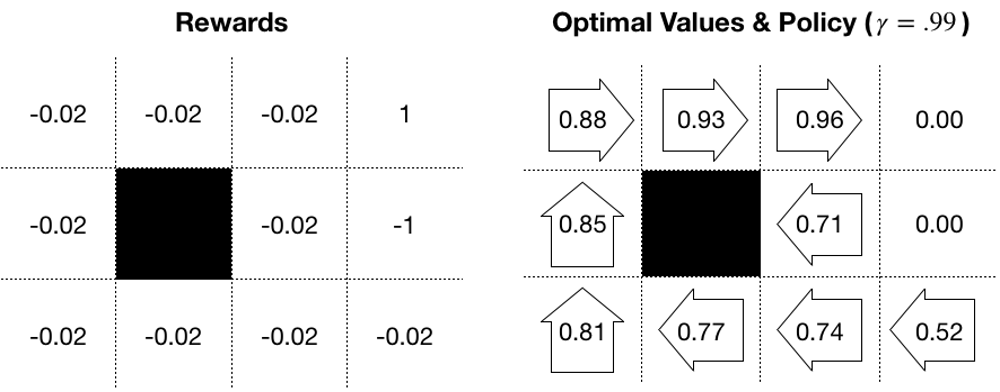

The right panel of the preceding GridWorld diagram shows the optimal value estimate that's produced by Value Iteration and the corresponding greedy policy. The negative rewards, combined with the uncertainty in the environment, produce an optimal policy that involves moving away from the negative terminal state.

The results are sensitive to both the rewards and the discount factor. The cost of the negative state affects the policy in the surrounding fields, and you should modify the example in the corresponding notebook to identify threshold levels that alter the optimal action selection.

## Imports & Settings

In [1]:
%matplotlib inline

from time import process_time
import numpy as np
import pandas as pd
from mdptoolbox import mdp
from itertools import product

## Set up Gridworld

### States, Actions and Rewards

We will begin by defining the environment parameters:

In [2]:
grid_size = (3, 4)
blocked_cell = (1, 1)
baseline_reward = -0.02
absorbing_cells = {(0, 3): 1, (1, 3): -1}

In [3]:
actions = ['L', 'U', 'R', 'D']
num_actions = len(actions)
probs = [.1, .8, .1, 0]

We will frequently need to convert between one-dimensional and two-dimensional representations, so we will define two helper functions for this purpose; states are one-dimensional and cells are the corresponding two-dimensional coordinates:

In [4]:
to_1d = lambda x: np.ravel_multi_index(x, grid_size)
to_2d = lambda x: np.unravel_index(x, grid_size)

Furthermore, we will precompute some data points to make the code more concise:

In [5]:
num_states = np.product(grid_size)
cells = list(np.ndindex(grid_size))
states = list(range(len(cells)))

In [6]:
cell_state = dict(zip(cells, states))
state_cell= dict(zip(states, cells))

In [7]:
absorbing_states = {to_1d(s):r for s, r in absorbing_cells.items()}
blocked_state = to_1d(blocked_cell)

We store the rewards for each state:

In [8]:
state_rewards = np.full(num_states, baseline_reward)
state_rewards[blocked_state] = 0
for state, reward in absorbing_states.items():
    state_rewards[state] = reward

In [9]:
action_outcomes = {}
for i, action in enumerate(actions):
    probs_ = dict(zip([actions[j % 4] for j in range(i, num_actions + i)], probs))
    action_outcomes[actions[(i + 1) % 4]] = probs_

To account for the probabilistic environment, we also need to compute the probability distribution over the actual move for a given action:

In [10]:
action_outcomes

{'U': {'L': 0.1, 'U': 0.8, 'R': 0.1, 'D': 0},
 'R': {'U': 0.1, 'R': 0.8, 'D': 0.1, 'L': 0},
 'D': {'R': 0.1, 'D': 0.8, 'L': 0.1, 'U': 0},
 'L': {'D': 0.1, 'L': 0.8, 'U': 0.1, 'R': 0}}

Now, we are ready to compute the transition matrix, which is the key input to the MDP.

### Transition Matrix

The transition matrix defines the probability to end up in a certain state, S, for each previous state and action, A, $P(s^\prime \mid s, a)$. We will demonstrate `pymdptoolbox`, and use one of the formats that's available to us to specify transitions and rewards. For both transition probabilities, we will create a `NumPy` array with dimensions of $A \times S \times S$.

First, we compute the target cell for each starting cell and move:

In [11]:
def get_new_cell(state, move):
    cell = to_2d(state)
    if actions[move] == 'U':
        return cell[0] - 1, cell[1]
    elif actions[move] == 'D':
        return cell[0] + 1, cell[1]
    elif actions[move] == 'R':
        return cell[0], cell[1] + 1
    elif actions[move] == 'L':
        return cell[0], cell[1] - 1

In [12]:
state_rewards

array([-0.02, -0.02, -0.02,  1.  , -0.02,  0.  , -0.02, -1.  , -0.02,
       -0.02, -0.02, -0.02])

The following function uses the argument's starting `state`, `action`, and `outcome` to fill in the transition probabilities and rewards:

In [13]:
def update_transitions_and_rewards(state, action, outcome):
    if state in absorbing_states.keys() or state == blocked_state:
        transitions[action, state, state] = 1
    else:
        new_cell = get_new_cell(state, outcome)
        p = action_outcomes[actions[action]][actions[outcome]]
        if new_cell not in cells or new_cell == blocked_cell:
            transitions[action, state, state] += p
            rewards[action, state, state] = baseline_reward
        else:
            new_state= to_1d(new_cell)
            transitions[action, state, new_state] = p
            rewards[action, state, new_state] = state_rewards[new_state]

We generate the transition and reward values by creating placeholder data structures and iterating over the Cartesian product of $A \times S \times S$, as follows:

In [14]:
rewards = np.zeros(shape=(num_actions, num_states, num_states))
transitions = np.zeros((num_actions, num_states, num_states))
actions_ = list(range(num_actions))
for action, outcome, state in product(actions_, actions_, states):
    update_transitions_and_rewards(state, action, outcome)

In [15]:
rewards.shape, transitions.shape

((4, 12, 12), (4, 12, 12))

## PyMDPToolbox

We can also solve MDPs using the [pymdptoolbox](https://pymdptoolbox.readthedocs.io/en/latest/api/mdptoolbox.html) Python library, which includes a few more algorithms, including Q-learning.

### Value Iteration

In [16]:
gamma = .99
epsilon = 1e-5

To run `ValueIteration`, just instantiate the corresponding object with the desired configuration options and the rewards and transition matrices before calling the `.run()` method:

In [17]:
vi = mdp.ValueIteration(transitions=transitions,
                        reward=rewards,
                        discount=gamma,
                        epsilon=epsilon)

vi.run()
f'# Iterations: {vi.iter:,d} | Time: {vi.time:.4f}'

'# Iterations: 31 | Time: 0.0012'

In [18]:
policy = np.asarray([actions[i] for i in vi.policy])
pd.DataFrame(policy.reshape(grid_size))

,0,1,2,3
0,R,R,R,L
1,U,L,U,L
2,U,L,L,L


In [19]:
value = np.asarray(vi.V).reshape(grid_size)
pd.DataFrame(value)

,0,1,2,3
0,0.884143,0.925054,0.961986,0.000000
1,0.848181,0.000000,0.714643,0.000000
2,0.808345,0.773328,0.736099,0.516083


### Policy Iteration

The `PolicyIteration` function works similarly:

In [20]:
pi = mdp.PolicyIteration(transitions=transitions,
                        reward=rewards,
                        discount=gamma,
                        max_iter=1000)

pi.run()
f'# Iterations: {pi.iter:,d} | Time: {pi.time:.4f}'

'# Iterations: 7 | Time: 0.0063'

It also yields the same policy, but the value function varies by run and does not need to achieve the optimal value before the policy converges.

In [21]:
policy = np.asarray([actions[i] for i in pi.policy])
pd.DataFrame(policy.reshape(grid_size))

,0,1,2,3
0,R,R,R,L
1,U,L,U,L
2,U,L,L,L


In [22]:
value = np.asarray(pi.V).reshape(grid_size)
pd.DataFrame(value)

,0,1,2,3
0,0.884143,0.925054,0.961986,1.594721e-16
1,0.848181,0.000000,0.714643,-0.000000e+00
2,0.808345,0.773328,0.736099,5.160828e-01


## Value Iteration

In [23]:
skip_states = list(absorbing_states.keys())+[blocked_state]
states_to_update = [s for s in states if s not in skip_states]

Then, we initialize the value function and set the discount factor gamma and the convergence threshold epsilon:

In [24]:
V = np.random.rand(num_states)
V[skip_states] = 0

In [25]:
gamma = .99
epsilon = 1e-5

The algorithm updates the value function using the Bellman optimality equation, and terminates when the L1 norm of V changes less than epsilon in absolute terms:

In [26]:
iterations = 0
start = process_time()
converged = False
while not converged:
    V_ = np.copy(V)
    for state in states_to_update:
        q_sa = np.sum(transitions[:, state] * (rewards[:, state] + gamma* V), axis=1)
        V[state] = np.max(q_sa)
    if np.sum(np.fabs(V - V_)) < epsilon:
        converged = True

    iterations += 1
    if iterations % 1000 == 0:
        print(np.sum(np.fabs(V - V_)))

f'# Iterations {iterations} | Time {process_time() - start:.4f}'

'# Iterations 18 | Time 0.0042'

### Value Function

In [27]:
print(pd.DataFrame(V.reshape(grid_size)))

          0         1         2         3
0  0.884143  0.925054  0.961986  0.000000
1  0.848181  0.000000  0.714643  0.000000
2  0.808345  0.773328  0.736099  0.516083


In [28]:
np.allclose(V.reshape(grid_size), np.asarray(vi.V).reshape(grid_size))

True

### Optimal Policy

In [29]:
for state, reward in absorbing_states.items():
    V[state] = reward

policy = np.argmax(np.sum(transitions * V, 2),0)
policy

array([2, 2, 2, 0, 1, 0, 0, 0, 1, 0, 0, 0])

In [30]:
pd.DataFrame(policy.reshape(grid_size)).replace(dict(enumerate(actions)))

,0,1,2,3
0,R,R,R,L
1,U,L,L,L
2,U,L,L,L


## Policy Iteration

Policy iterations involves separate evaluation and improvement steps. We define the improvement part by selecting the action that maximizes the sum of expected reward and next-state value. Note that we temporarily fill in the rewards for the terminal states to avoid ignoring actions that would lead us there:

In [31]:
def policy_improvement(value, transitions):
    for state, reward in absorbing_states.items():
        value[state] = reward
    return np.argmax(np.sum(transitions * value, 2),0)

In [32]:
V = np.random.rand(num_states)
V[skip_states] = 0
pi = np.random.choice(list(range(num_actions)), size=num_states)

The algorithm alternates between policy evaluation for a greedily selected action and policy improvement until the policy stabilizes:

In [33]:
iterations = 0
start = process_time()
converged = False
while not converged:
    pi_ = np.copy(pi)
    for state in states_to_update:
        action = policy[state]
        V[state] = np.dot(transitions[action, state], (rewards[action, state] + gamma* V))
        pi = policy_improvement(V.copy(), transitions)
    if np.array_equal(pi_, pi):
        converged = True
    iterations += 1

f'# Iterations {iterations} | Time {process_time() - start:.4f}'

'# Iterations 4 | Time 0.0044'

Policy iteration converges after only three iterations. The policy stabilizes before the algorithm finds the optimal value function, and the optimal policy differs slightly, most notably by suggesting up instead of the safer left for the field next to the negative terminal state. This can be avoided by tightening the convergence criteria, for example, by requiring a stable policy of several rounds or adding a threshold for the value function.

In [34]:
pd.DataFrame(pi.reshape(grid_size)).replace(dict(enumerate(actions)))

,0,1,2,3
0,R,R,R,L
1,U,L,U,L
2,U,L,L,L


In [35]:
pd.DataFrame(V.reshape(grid_size))

,0,1,2,3
0,0.785945,0.887662,0.935292,0.000000
1,0.722962,0.000000,0.497782,0.000000
2,0.660255,0.606994,0.558676,0.354314


# References
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

- https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/22_deep_reinforcement_learning/01_gridworld_dynamic_programming.ipynb
- Jansen, Stefan. Hands-On Machine Learning for Algorithmic Trading: Design and implement investment strategies based on smart algorithms that learn from data using Python. Packt Publishing Ltd, 2018.

</font>
</div>